* classification / regression : 지도학습
* clustering / dimensionality reduction : 비지도학습

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("data/diabetes.csv")
df.shape

(768, 9)

In [3]:
# 전처리 할 때 이전에는 BMI가 0인 것 등을 중앙값, 평균값으로 바꿨었다.

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 학습, 예측 데이터셋 나누기

* 보통 예측 데이터보다 학습 데이터가 많아야지 좀 더 잘 학습됨
* Insulin 값을 예측해서 결측치를 채우는 것이 목표이기 때문에, 인슐린 값이 0일때가 결측치라고 볼 수 있으므로 이를 기준으로 나눈다.

In [4]:
(df['Insulin'] > 0).value_counts()

True     394
False    374
Name: Insulin, dtype: int64

In [5]:
# train set
train = df[df['Insulin'] > 0].copy()
train.shape

(394, 9)

In [6]:
# test set
test = df[df['Insulin'] == 0].copy()
test.shape

(374, 9)

## EDA

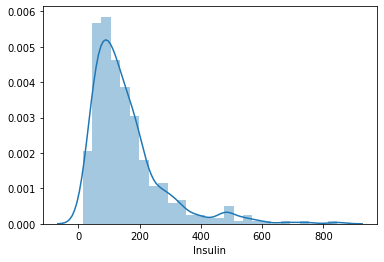

In [7]:
sns.distplot(train['Insulin'])

# 600 이상 정도에 이상치가 많다.

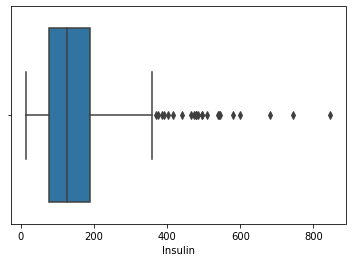

In [8]:
sns.boxplot(train['Insulin'])

In [9]:
desc = train['Insulin'].describe()
desc

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

In [10]:
# Outlier
IQR = desc.loc['75%'] - desc.loc['25%']
OUT = (IQR * 1.5) + desc.loc['75%']

In [11]:
train[train['Insulin'] > OUT].shape

(24, 9)

In [12]:
print(train.shape) # 얘 원래 print하면 (394, 9) 였음!!
## train = train[train['Insulin'] < 600] ; 우선 위에 24개 다 지우면 너무 적어지니까, 600 이상의 진짜 극단적인 애들만 지워준다. 그리고 그걸 train set으로한다.
train = train[train['Insulin'] < OUT] # 이번엔 OUT 다 제거
train.shape

(394, 9)


(370, 9)

## 학습, 예측에 사용할 컬럼

In [13]:
feature_names = test.columns.tolist()
feature_names.remove('Insulin')
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

## 정답값이자 예측해야 될 값

In [14]:
label_name = 'Insulin'
label_name

'Insulin'

## 학습, 예측 데이터셋 만들기

In [15]:
X_train = train[feature_names]
X_train.shape

(370, 8)

In [16]:
y_train = train[label_name]
y_train.shape

(370,)

In [17]:
X_test = test[feature_names]
X_test.shape

(374, 8)

In [18]:
y_test = test[label_name]
y_test.shape #어차피 다 0

(374,)

## 머신러닝 알고리즘 가져오기

* Ridge,Lasso,Elastic Net 이 있지만, classifier에도 사용 가능한 tree 기반 알고리즘 사용

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


estimators = [DecisionTreeRegressor(random_state=42),
         RandomForestRegressor(random_state=42),
         GradientBoostingRegressor(random_state=42)]

estimators

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False),
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
            

In [20]:
max_depth = np.random.randint(5, 30, 10)
max_depth

array([12,  7, 13, 15, 24, 24, 11,  5, 19, 10])

In [21]:
max_features = np.random.uniform(0.3, 1.0, 10)
max_features

array([0.90335631, 0.64217525, 0.57311986, 0.89322825, 0.57874838,
       0.49462441, 0.94007808, 0.98837699, 0.64860791, 0.46754794])

In [26]:
results = []
for estimator in estimators:
    result = []
    result.append(estimator.__class__.__name__)
    results.append(result)
    
pd.DataFrame(results)

,0
0,DecisionTreeRegressor
1,RandomForestRegressor
2,GradientBoostingRegressor


In [29]:
from sklearn.model_selection import RandomizedSearchCV

results = []
for estimator in estimators:
    result = []
    
    
    max_depth = np.random.randint(5, 30, 10)
    max_features = np.random.uniform(0.3, 1.0, 10)

    param_distributions = {'max_depth' : max_depth, 'max_features' : max_features }

    regressor = RandomizedSearchCV(estimator,
                      param_distributions,
                      n_iter=10,
                      scoring=None,
                      n_jobs=None,
                      cv=5,
                      verbose=2, 
                      random_state=42)

    regressor.fit(X_train, y_train)
    
    result.append(estimator.__class__.__name__)
    result.append(regressor.best_params_)
    result.append(regressor.best_estimator_)
    result.append(regressor.best_score_)
    result.append(regressor.cv_results_)
    results.append(result)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_features=0.6208600236574925, max_depth=23 ...................
[CV] .... max_features=0.6208600236574925, max_depth=23, total=   0.0s
[CV] max_features=0.6208600236574925, max_depth=23 ...................
[CV] .... max_features=0.6208600236574925, max_depth=23, total=   0.0s
[CV] max_features=0.6208600236574925, max_depth=23 ...................
[CV] .... max_features=0.6208600236574925, max_depth=23, total=   0.0s
[CV] max_features=0.6208600236574925, max_depth=23 ...................
[CV] .... max_features=0.6208600236574925, max_depth=23, total=   0.0s
[CV] max_features=0.6208600236574925, max_depth=23 ...................
[CV] .... max_features=0.6208600236574925, max_depth=23, total=   0.0s
[CV] max_features=0.6208600236574925, max_depth=7 ....................
[CV] ..... max_features=0.6208600236574925, max_depth=7, total=   0.0s
[CV] max_features=0.6208600236574925, max_depth=7 ....................
[CV] ..... max_f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..... max_features=0.6208600236574925, max_depth=7, total=   0.0s
[CV] max_features=0.41866714201315436, max_depth=11 ..................
[CV] ... max_features=0.41866714201315436, max_depth=11, total=   0.0s
[CV] max_features=0.41866714201315436, max_depth=11 ..................
[CV] ... max_features=0.41866714201315436, max_depth=11, total=   0.0s
[CV] max_features=0.41866714201315436, max_depth=11 ..................
[CV] ... max_features=0.41866714201315436, max_depth=11, total=   0.0s
[CV] max_features=0.41866714201315436, max_depth=11 ..................
[CV] ... max_features=0.41866714201315436, max_depth=11, total=   0.0s
[CV] max_features=0.41866714201315436, max_depth=11 ..................
[CV] ... max_features=0.41866714201315436, max_depth=11, total=   0.0s
[CV] max_features=0.5150743396919608, max_depth=22 ...................
[CV] .... max_features=0.5150743396919608, max_depth=22, total=   0.0s
[CV] max_features=0.5150743396919608, max_depth=22 ...................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_features=0.9138837469457095, max_depth=8 ....................
[CV] ..... max_features=0.9138837469457095, max_depth=8, total=   0.5s
[CV] max_features=0.9138837469457095, max_depth=8 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ..... max_features=0.9138837469457095, max_depth=8, total=   0.4s
[CV] max_features=0.9138837469457095, max_depth=8 ....................
[CV] ..... max_features=0.9138837469457095, max_depth=8, total=   0.5s
[CV] max_features=0.9138837469457095, max_depth=8 ....................
[CV] ..... max_features=0.9138837469457095, max_depth=8, total=   0.6s
[CV] max_features=0.9138837469457095, max_depth=8 ....................
[CV] ..... max_features=0.9138837469457095, max_depth=8, total=   0.8s
[CV] max_features=0.9138837469457095, max_depth=8 ....................
[CV] ..... max_features=0.9138837469457095, max_depth=8, total=   0.6s
[CV] max_features=0.9138837469457095, max_depth=8 ....................
[CV] ..... max_features=0.9138837469457095, max_depth=8, total=   0.6s
[CV] max_features=0.9138837469457095, max_depth=8 ....................
[CV] ..... max_features=0.9138837469457095, max_depth=8, total=   0.5s
[CV] max_features=0.9138837469457095, max_depth=8 ....................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   34.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_features=0.7780314108141955, max_depth=14 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... max_features=0.7780314108141955, max_depth=14, total=   0.5s
[CV] max_features=0.7780314108141955, max_depth=14 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .... max_features=0.7780314108141955, max_depth=14, total=   0.5s
[CV] max_features=0.7780314108141955, max_depth=14 ...................
[CV] .... max_features=0.7780314108141955, max_depth=14, total=   0.8s
[CV] max_features=0.7780314108141955, max_depth=14 ...................
[CV] .... max_features=0.7780314108141955, max_depth=14, total=   0.6s
[CV] max_features=0.7780314108141955, max_depth=14 ...................
[CV] .... max_features=0.7780314108141955, max_depth=14, total=   0.7s
[CV] max_features=0.7780314108141955, max_depth=8 ....................
[CV] ..... max_features=0.7780314108141955, max_depth=8, total=   0.5s
[CV] max_features=0.7780314108141955, max_depth=8 ....................
[CV] ..... max_features=0.7780314108141955, max_depth=8, total=   0.6s
[CV] max_features=0.7780314108141955, max_depth=8 ....................
[CV] ..... max_features=0.7780314108141955, max_depth=8, total=   0.6s
[CV] max_features=0.7780314108141955, max_depth=8 ....................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   24.6s finished


In [31]:
df_cv = pd.DataFrame(results)
df_cv.columns = ['model', 'params', 'estimator', 'score', 'cv_result']
df_cv

,model,params,estimator,score,cv_result
0,DecisionTreeRegressor,"{'max_features': 0.6208600236574925, 'max_dept...","DecisionTreeRegressor(ccp_alpha=0.0, criterion...",-0.026676,"{'mean_fit_time': [0.012645435333251954, 0.009..."
1,RandomForestRegressor,"{'max_features': 0.7878570676024264, 'max_dept...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.337769,"{'mean_fit_time': [0.5356671333312988, 0.52579..."
2,GradientBoostingRegressor,"{'max_features': 0.39910841607186176, 'max_dep...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.290698,"{'mean_fit_time': [0.5961803436279297, 0.53883..."


In [34]:
best_estimator = df_cv.loc[1, 'estimator']
best_estimator

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.7878570676024264,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

## 학습(훈련)

In [39]:
best_estimator.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.7878570676024264,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

## Cross Validation으로 학습 세트의 오차 측정하기

In [41]:
from sklearn.model_selection import cross_val_predict

y_predict = cross_val_predict(best_estimator, X_train, y_train, cv=5, verbose=2, n_jobs=-1)
y_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


array([ 47.61030111, 175.69931161,  78.60077778, 139.61544954,
       190.00232378])

In [42]:
# 정답을 정확하게 맞춘 개수 394개 중 3개
# 이상치 600이상을 제거하고나서는 5개로 증가, OUT 제거는 7

(y_predict == y_train).sum()

0

In [43]:
len(y_train)

370

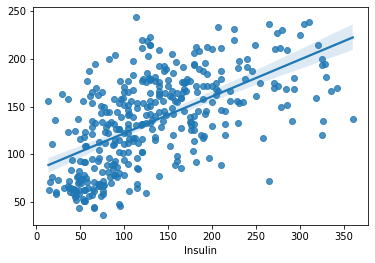

In [44]:
sns.regplot(y_train, y_predict)

In [45]:
from sklearn.metrics import r2_score

r2_score(y_train, y_predict)

0.34815966287026323

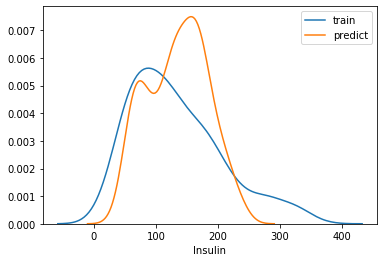

In [46]:
sns.distplot(y_train, hist=False, label='train')
sns.distplot(y_predict, hist=False, label='predict')

## 오차 구하기

In [47]:
# MAE
# 86 -> 77.55(600이상 outlier 삭제) -> 62.056(OUT 제거) -> 44.804(RandomForest)
error = abs(y_train - y_predict)
error.mean()

44.80468256735728

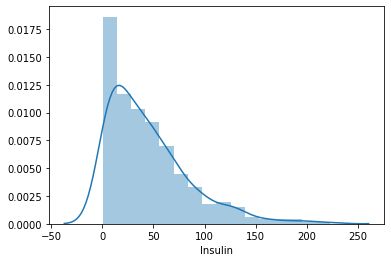

In [48]:
sns.distplot(error)

In [49]:
error.describe()

count    370.000000
mean      44.804683
std       39.801551
min        0.201618
25%       13.578759
50%       35.312298
75%       65.354112
max      223.076276
Name: Insulin, dtype: float64

In [50]:
# RMSE
# 126.895 -> 114.077 -> 84.111 -> 59.894

np.sqrt(((y_train - y_predict)**2).mean())

59.894420096016695

## 트리 알고리즘 분석하기

* 의사결정나무를 시각화 합니다
* 피처의 중요도를 구합니다

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
tree = plot_tree(model, feature_names = feature_names, filled=True, fontsize=10)

In [52]:
# 피처의 중요도를 추출하기
best_estimator.feature_importances_

array([0.04566387, 0.4319703 , 0.06828978, 0.09138994, 0.12462714,
       0.10451841, 0.10160765, 0.03193291])

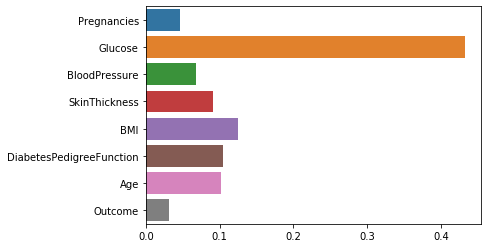

In [53]:
# 피처의 중요도 시각화 하기
sns.barplot(x=best_estimator.feature_importances_, y=feature_names)

## 예측

In [54]:
y_test = best_estimator.predict(X_test)
y_test[:5]

array([188.65200346,  53.46791512, 184.16854762, 148.40936334,
       173.67370037])

In [55]:
train.groupby("Outcome")['Insulin'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,254.0,115.917323,69.844697,15.0,64.25,100.0,151.00,342.0
1,116.0,169.163793,70.789454,14.0,124.25,160.0,207.75,360.0


In [56]:
test['Insulin'] = y_test

In [57]:
test.groupby("Outcome")['Insulin'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,236.0,131.197769,46.328895,47.063334,86.898205,138.441065,170.691188,220.807847
1,138.0,173.561651,31.464275,85.483921,155.021531,173.056647,194.909399,250.998905


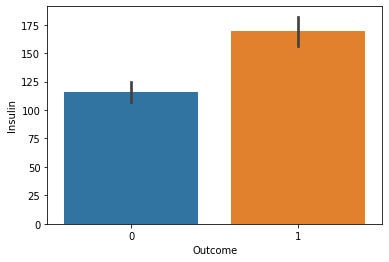

In [58]:
# Outcome에 따른 Insulin의 평균값
sns.barplot(data=train, x='Outcome', y='Insulin')

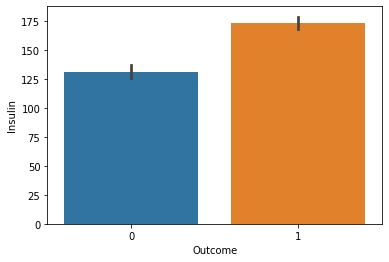

In [59]:
# 예측값에 대한 시각화
sns.barplot(data=test, x='Outcome', y='Insulin')

## 예측값을 CSV 파일로 저장하기

In [60]:
df.loc[df['Insulin']==0, 'Insulin']

0      0
1      0
2      0
5      0
7      0
      ..
761    0
762    0
764    0
766    0
767    0
Name: Insulin, Length: 374, dtype: int64

In [61]:
test['Insulin']

0      188.652003
1       53.467915
2      184.168548
5      148.409363
7      173.673700
          ...    
761    201.551630
762     72.096584
764    157.728973
766    163.080322
767     77.651867
Name: Insulin, Length: 374, dtype: float64

In [62]:
df.loc[df['Insulin'] == 0, 'Insulin'] = test['Insulin']

In [63]:
df # 원래 Insulin이 0이었는데, 우리가 예측한 값으로 채워졌다.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,188.652003,33.6,0.627,50,1
1,1,85,66,29,53.467915,26.6,0.351,31,0
2,8,183,64,0,184.168548,23.3,0.672,32,1
3,1,89,66,23,94.000000,28.1,0.167,21,0
4,0,137,40,35,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.000000,32.9,0.171,63,0
764,2,122,70,27,157.728973,36.8,0.340,27,0
765,5,121,72,23,112.000000,26.2,0.245,30,0
766,1,126,60,0,163.080322,30.1,0.349,47,1


In [66]:
df.to_csv('data/diabetes_fill_insulin.csv', index=False)

In [67]:
pd.read_csv('data/diabetes_fill_insulin.csv')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,188.652003,33.6,0.627,50,1
1,1,85,66,29,53.467915,26.6,0.351,31,0
2,8,183,64,0,184.168548,23.3,0.672,32,1
3,1,89,66,23,94.000000,28.1,0.167,21,0
4,0,137,40,35,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.000000,32.9,0.171,63,0
764,2,122,70,27,157.728973,36.8,0.340,27,0
765,5,121,72,23,112.000000,26.2,0.245,30,0
766,1,126,60,0,163.080322,30.1,0.349,47,1
